# Домашнее задание. Нейросетевая классификация текстов

В этом домашнем задании вам предстоит самостоятельно решить задачу классификации текстов на основе семинарского кода. Мы будем использовать датасет [ag_news](https://paperswithcode.com/dataset/ag-news). Это датасет для классификации новостей на 4 темы: "World", "Sports", "Business", "Sci/Tech".

Установим модуль datasets, чтобы нам проще было работать с данными.

In [1]:
!pip install datasets

Импорт необходимых библиотек

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import datasets

import numpy as np
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from datasets import load_dataset
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
import nltk

from collections import Counter
from typing import List
import string

import seaborn
seaborn.set(palette='summer')

In [3]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Подготовка данных
Для вашего удобства, мы привели код обработки датасета в ноутбуке. Ваша задача --- обучить модель, которая получит максимальное возможное качество на тестовой части.

In [5]:
# Загрузим датасет
!pip install -U datasets
dataset = datasets.load_dataset('ag_news')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Как и в семинаре, выполним следующие шаги:
* Составим словарь
* Создадим класс WordDataset
* Выделим обучающую и тестовую часть, создадим DataLoader-ы.

In [6]:
words = Counter()
nltk.download('punkt')
nltk.download('punkt_tab')
for example in tqdm(dataset['train']['text']):
    # Приводим к нижнему регистру и убираем пунктуацию
    prccessed_text = example.lower().translate(
        str.maketrans('', '', string.punctuation))

    for word in word_tokenize(prccessed_text):
        words[word] += 1


vocab = set(['<unk>', '<bos>', '<eos>', '<pad>'])
counter_threshold = 25

for char, cnt in words.items():
    if cnt > counter_threshold:
        vocab.add(char)

print(f'Размер словаря: {len(vocab)}')

word2ind = {char: i for i, char in enumerate(vocab)}
ind2word = {i: char for char, i in word2ind.items()}

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


  0%|          | 0/120000 [00:00<?, ?it/s]

Размер словаря: 11842


In [7]:
class WordDataset:
    def __init__(self, sentences):
        self.data = sentences
        self.unk_id = word2ind['<unk>']
        self.bos_id = word2ind['<bos>']
        self.eos_id = word2ind['<eos>']
        self.pad_id = word2ind['<pad>']

    def __getitem__(self, idx: int) -> List[int]:
        processed_text = self.data[idx]['text'].lower().translate(
            str.maketrans('', '', string.punctuation))
        tokenized_sentence = [self.bos_id]
        tokenized_sentence += [
            word2ind.get(word, self.unk_id) for word in word_tokenize(processed_text)
            ]
        tokenized_sentence += [self.eos_id]

        train_sample = {
            "text": tokenized_sentence,
            "label": self.data[idx]['label']
        }

        return train_sample

    def __len__(self) -> int:
        return len(self.data)


def collate_fn_with_padding(
    input_batch: List[List[int]], pad_id=word2ind['<pad>'], max_len=256) -> torch.Tensor:
    seq_lens = [len(x['text']) for x in input_batch]
    max_seq_len = min(max(seq_lens), max_len)

    new_batch = []
    for sequence in input_batch:
        sequence['text'] = sequence['text'][:max_seq_len]
        for _ in range(max_seq_len - len(sequence['text'])):
            sequence['text'].append(pad_id)

        new_batch.append(sequence['text'])

    sequences = torch.LongTensor(new_batch).to(device)
    labels = torch.LongTensor([x['label'] for x in input_batch]).to(device)

    new_batch = {
        'input_ids': sequences,
        'label': labels
    }

    return new_batch

In [8]:
train_dataset = WordDataset(dataset['train'])

np.random.seed(42)
idx = np.random.choice(np.arange(len(dataset['test'])), 5000)
eval_dataset = WordDataset(dataset['test'].select(idx))

batch_size = 32
train_dataloader = DataLoader(
    train_dataset, shuffle=True, collate_fn=collate_fn_with_padding, batch_size=batch_size)

eval_dataloader = DataLoader(
    eval_dataset, shuffle=False, collate_fn=collate_fn_with_padding, batch_size=batch_size)

## Постановка задачи
Ваша задача -- получить максимальное возможное accuracy на `eval_dataloader`. Ниже приведена функция, которую вам необходимо запустить для обученной модели, чтобы вычислить качество её работы.

In [9]:
def evaluate(model, eval_dataloader) -> float:
    """
    Calculate accuracy on validation dataloader.
    """

    predictions = []
    target = []
    with torch.no_grad():
        for batch in eval_dataloader:
            logits = model(batch['input_ids'])
            predictions.append(logits.argmax(dim=1))
            target.append(batch['label'])

    predictions = torch.cat(predictions)
    target = torch.cat(target)
    accuracy = (predictions == target).float().mean().item()

    return accuracy

## Ход работы
Оценка за домашнее задание складывается из четырех частей:
### Запуск базовой модели с семинара на новом датасете (1 балл)
На семинаре мы создали модель, которая дает на нашей задаче довольно высокое качество. Ваша цель --- обучить ее и вычислить `score`, который затем можно будет использовать в качестве бейзлайна.

В модели появится одно важное изменение: количество классов теперь равно не 2, а 4. Обратите на это внимание и найдите, что в коде создания модели нужно модифицировать, чтобы учесть это различие.

### Проведение экспериментов по улучшению модели (2 балла за каждый эксперимент)
Чтобы улучшить качество базовой модели, можно попробовать различные идеи экспериментов. Каждый выполненный эксперимент будет оцениваться в 2 балла. Для получения полного балла за этот пункт вам необходимо выполнить по крайней мере 2 эксперимента. Не расстраивайтесь, если какой-то эксперимент не дал вам прироста к качеству: он все равно зачтется, если выполнен корректно.

Вот несколько идей экспериментов:
* **Модель RNN**. Попробуйте другие нейросетевые модели --- LSTM и GRU. Мы советуем обратить внимание на [GRU](https://pytorch.org/docs/stable/generated/torch.nn.GRU.html), так как интерфейс этого класса ничем не отличается от обычной Vanilla RNN, которую мы использовали на семинаре.
* **Увеличение количества рекуррентных слоев модели**. Это можно сделать с помощью параметра `num_layers` в классе `nn.RNN`. В такой модели выходы первой RNN передаются в качестве входов второй RNN и так далее.
* **Изменение архитектуры после применения RNN**. В базовой модели используется агрегация со всех эмбеддингов. Возможно, вы захотите конкатенировать результат агрегации и эмбеддинг с последнего токена.
* **Подбор гиперпараметров и обучение до сходимости**. Возможно, для получения более высокого качества просто необходимо увеличить количество эпох обучения нейросети, а также попробовать различные гиперпараметры: размер словаря, `dropout_rate`, `hidden_dim`.

Обратите внимание, что главное правило проведения экспериментов --- необходимо совершать одно архитектурное изменение в одном эксперименте. Если вы совершите несколько изменений, то будет неясно, какое именно из изменений дало прирост к качеству.

### Получение высокого качества (3 балла)
В конце вашей работы вы должны указать, какая из моделей дала лучший результат, и вывести качество, которое дает лучшая модель, с помощью функции `evaluate`. Ваша модель будет оцениваться по метрике `accuracy` следующим образом:
* $accuracy < 0.9$ --- 0 баллов;
* $0.9 \leqslant accuracy < 0.91$ --- 1 балл;
* $0.91 \leqslant accuracy < 0.915$ --- 2 балла;
* $0.915 \leqslant accuracy$ --- 3 балла.

### Оформление отчета (2 балла)
В конце работы подробно опишите все проведенные эксперименты.
* Укажите, какие из экспериментов принесли улучшение, а какие --- нет.
* Проанализируйте графики сходимости моделей в проведенных экспериментах. Являются ли колебания качества обученных моделей существенными в зависимости от эпохи обучения, или же сходимость стабильная?
* Укажите, какая модель получилась оптимальной.

Желаем удачи!

In [31]:
class CharLM(nn.Module):
  def __init__(
        self, vocab_size: int, hidden_dim : int = 256,num_classes: int = 4,
        aggregation_type: str = 'max'
        ):
    super().__init__()



    self.embedding = nn.Embedding(vocab_size,hidden_dim)
    self.rnn = nn.RNN(hidden_dim,hidden_dim, batch_first=True)
    self.linear = nn.Linear(hidden_dim, hidden_dim)
    self.proj = nn.Linear(hidden_dim, num_classes)


    self.non_lin = nn.Tanh()


    self.aggregation_type = aggregation_type


  def forward(self, batch_input):
    embeddings = self.embedding(batch_input)
    output , _ = self.rnn(embeddings)


    if self.aggregation_type == 'max':
      output = output.max(dim = 1)[0]
    else:
      output = output.mean(dim = 1)


    output = self.linear(self.non_lin(output))
    prediction = self.proj(self.non_lin(output))



    return prediction



In [32]:
import torch.optim as optim

len_vocab = len(vocab)
model = CharLM(
    vocab_size=len_vocab,
)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = optim.Adam(model.parameters())
print(len(train_dataloader))

3750


In [36]:
num_epochs = 25
save_accuracy = []
break_point = 250
model = model.to(device)
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0

    for i, batch in enumerate(tqdm(train_dataloader, desc=f"Epoch {epoch+1}")):
        batch['input_ids'] = batch['input_ids'].to(device)
        batch['label'] = batch['label'].to(device)
        optimizer.zero_grad()
        outputs = model(batch['input_ids'])
        loss = criterion(outputs, batch['label'])
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()


        if (i % break_point == 0) and (i > 0):
            model.eval()
            with torch.no_grad():
                accuracy = evaluate(model, eval_dataloader)
            save_accuracy.append(accuracy)
            model.train()

            avg_loss = epoch_loss / (i + 1)
            print(f"Epoch {epoch + 1}, Step {i}, Avg Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}")


    model.eval()
    with torch.no_grad():
        final_accuracy = evaluate(model, eval_dataloader)
    save_accuracy.append(final_accuracy)
    model.train()

    print(f"End of Epoch {epoch + 1}, Final Accuracy: {final_accuracy:.4f}")
    print("-" * 50)


Epoch 1:   0%|          | 0/3750 [00:00<?, ?it/s]

Epoch 1, Step 250, Avg Loss: 0.9320, Accuracy: 0.8148
Epoch 1, Step 500, Avg Loss: 0.7230, Accuracy: 0.8156
Epoch 1, Step 750, Avg Loss: 0.6290, Accuracy: 0.8396
Epoch 1, Step 1000, Avg Loss: 0.5689, Accuracy: 0.8694
Epoch 1, Step 1250, Avg Loss: 0.5285, Accuracy: 0.8652
Epoch 1, Step 1500, Avg Loss: 0.5024, Accuracy: 0.8742
Epoch 1, Step 1750, Avg Loss: 0.4830, Accuracy: 0.8712
Epoch 1, Step 2000, Avg Loss: 0.4650, Accuracy: 0.8784
Epoch 1, Step 2250, Avg Loss: 0.4530, Accuracy: 0.8776
Epoch 1, Step 2500, Avg Loss: 0.4418, Accuracy: 0.8780
Epoch 1, Step 2750, Avg Loss: 0.4317, Accuracy: 0.8848
Epoch 1, Step 3000, Avg Loss: 0.4231, Accuracy: 0.8756
Epoch 1, Step 3250, Avg Loss: 0.4145, Accuracy: 0.8852
Epoch 1, Step 3500, Avg Loss: 0.4073, Accuracy: 0.8930
End of Epoch 1, Final Accuracy: 0.8940
--------------------------------------------------


Epoch 2:   0%|          | 0/3750 [00:00<?, ?it/s]

Epoch 2, Step 250, Avg Loss: 0.2838, Accuracy: 0.8790
Epoch 2, Step 500, Avg Loss: 0.2799, Accuracy: 0.8746
Epoch 2, Step 750, Avg Loss: 0.2837, Accuracy: 0.8868
Epoch 2, Step 1000, Avg Loss: 0.2822, Accuracy: 0.8884
Epoch 2, Step 1250, Avg Loss: 0.2841, Accuracy: 0.8890
Epoch 2, Step 1500, Avg Loss: 0.2833, Accuracy: 0.8884
Epoch 2, Step 1750, Avg Loss: 0.2811, Accuracy: 0.8966
Epoch 2, Step 2000, Avg Loss: 0.2781, Accuracy: 0.8914
Epoch 2, Step 2250, Avg Loss: 0.2776, Accuracy: 0.8940
Epoch 2, Step 2500, Avg Loss: 0.2779, Accuracy: 0.9012
Epoch 2, Step 2750, Avg Loss: 0.2777, Accuracy: 0.8930
Epoch 2, Step 3000, Avg Loss: 0.2773, Accuracy: 0.8900
Epoch 2, Step 3250, Avg Loss: 0.2773, Accuracy: 0.8884
Epoch 2, Step 3500, Avg Loss: 0.2771, Accuracy: 0.9008
End of Epoch 2, Final Accuracy: 0.8994
--------------------------------------------------


Epoch 3:   0%|          | 0/3750 [00:00<?, ?it/s]

Epoch 3, Step 250, Avg Loss: 0.2172, Accuracy: 0.8794
Epoch 3, Step 500, Avg Loss: 0.2220, Accuracy: 0.9010
Epoch 3, Step 750, Avg Loss: 0.2262, Accuracy: 0.8968
Epoch 3, Step 1000, Avg Loss: 0.2313, Accuracy: 0.9002
Epoch 3, Step 1250, Avg Loss: 0.2315, Accuracy: 0.8844
Epoch 3, Step 1500, Avg Loss: 0.2333, Accuracy: 0.8982
Epoch 3, Step 1750, Avg Loss: 0.2358, Accuracy: 0.8890
Epoch 3, Step 2000, Avg Loss: 0.2364, Accuracy: 0.8976
Epoch 3, Step 2250, Avg Loss: 0.2368, Accuracy: 0.8982
Epoch 3, Step 2500, Avg Loss: 0.2373, Accuracy: 0.8958
Epoch 3, Step 2750, Avg Loss: 0.2390, Accuracy: 0.9026
Epoch 3, Step 3000, Avg Loss: 0.2401, Accuracy: 0.8906
Epoch 3, Step 3250, Avg Loss: 0.2388, Accuracy: 0.8970
Epoch 3, Step 3500, Avg Loss: 0.2404, Accuracy: 0.8996
End of Epoch 3, Final Accuracy: 0.8944
--------------------------------------------------


Epoch 4:   0%|          | 0/3750 [00:00<?, ?it/s]

Epoch 4, Step 250, Avg Loss: 0.2092, Accuracy: 0.8998
Epoch 4, Step 500, Avg Loss: 0.2089, Accuracy: 0.8996
Epoch 4, Step 750, Avg Loss: 0.2115, Accuracy: 0.8924
Epoch 4, Step 1000, Avg Loss: 0.2117, Accuracy: 0.8964
Epoch 4, Step 1250, Avg Loss: 0.2151, Accuracy: 0.8922
Epoch 4, Step 1500, Avg Loss: 0.2155, Accuracy: 0.8994
Epoch 4, Step 1750, Avg Loss: 0.2159, Accuracy: 0.8922
Epoch 4, Step 2000, Avg Loss: 0.2169, Accuracy: 0.8944
Epoch 4, Step 2250, Avg Loss: 0.2171, Accuracy: 0.8992
Epoch 4, Step 2500, Avg Loss: 0.2181, Accuracy: 0.8864
Epoch 4, Step 2750, Avg Loss: 0.2183, Accuracy: 0.8956
Epoch 4, Step 3000, Avg Loss: 0.2195, Accuracy: 0.8920
Epoch 4, Step 3250, Avg Loss: 0.2200, Accuracy: 0.9008
Epoch 4, Step 3500, Avg Loss: 0.2203, Accuracy: 0.8920
End of Epoch 4, Final Accuracy: 0.9006
--------------------------------------------------


Epoch 5:   0%|          | 0/3750 [00:00<?, ?it/s]

Epoch 5, Step 250, Avg Loss: 0.1963, Accuracy: 0.9038
Epoch 5, Step 500, Avg Loss: 0.1947, Accuracy: 0.8918
Epoch 5, Step 750, Avg Loss: 0.1966, Accuracy: 0.8920
Epoch 5, Step 1000, Avg Loss: 0.1941, Accuracy: 0.9022
Epoch 5, Step 1250, Avg Loss: 0.1950, Accuracy: 0.9014
Epoch 5, Step 1500, Avg Loss: 0.1962, Accuracy: 0.9014
Epoch 5, Step 1750, Avg Loss: 0.1971, Accuracy: 0.8882
Epoch 5, Step 2000, Avg Loss: 0.1983, Accuracy: 0.9004
Epoch 5, Step 2250, Avg Loss: 0.1989, Accuracy: 0.9014
Epoch 5, Step 2500, Avg Loss: 0.2010, Accuracy: 0.9034
Epoch 5, Step 2750, Avg Loss: 0.2012, Accuracy: 0.8976
Epoch 5, Step 3000, Avg Loss: 0.2025, Accuracy: 0.9012
Epoch 5, Step 3250, Avg Loss: 0.2030, Accuracy: 0.8992
Epoch 5, Step 3500, Avg Loss: 0.2024, Accuracy: 0.9098
End of Epoch 5, Final Accuracy: 0.9014
--------------------------------------------------


Epoch 6:   0%|          | 0/3750 [00:00<?, ?it/s]

Epoch 6, Step 250, Avg Loss: 0.1734, Accuracy: 0.9020
Epoch 6, Step 500, Avg Loss: 0.1801, Accuracy: 0.8994
Epoch 6, Step 750, Avg Loss: 0.1824, Accuracy: 0.9016
Epoch 6, Step 1000, Avg Loss: 0.1842, Accuracy: 0.8970
Epoch 6, Step 1250, Avg Loss: 0.1831, Accuracy: 0.9002
Epoch 6, Step 1500, Avg Loss: 0.1836, Accuracy: 0.9016
Epoch 6, Step 1750, Avg Loss: 0.1839, Accuracy: 0.8948
Epoch 6, Step 2000, Avg Loss: 0.1854, Accuracy: 0.9064
Epoch 6, Step 2250, Avg Loss: 0.1863, Accuracy: 0.9044
Epoch 6, Step 2500, Avg Loss: 0.1872, Accuracy: 0.9040
Epoch 6, Step 2750, Avg Loss: 0.1878, Accuracy: 0.9002
Epoch 6, Step 3000, Avg Loss: 0.1890, Accuracy: 0.9028
Epoch 6, Step 3250, Avg Loss: 0.1894, Accuracy: 0.9066
Epoch 6, Step 3500, Avg Loss: 0.1894, Accuracy: 0.9050
End of Epoch 6, Final Accuracy: 0.9006
--------------------------------------------------


Epoch 7:   0%|          | 0/3750 [00:00<?, ?it/s]

Epoch 7, Step 250, Avg Loss: 0.1618, Accuracy: 0.9050
Epoch 7, Step 500, Avg Loss: 0.1619, Accuracy: 0.8942
Epoch 7, Step 750, Avg Loss: 0.1668, Accuracy: 0.9030
Epoch 7, Step 1000, Avg Loss: 0.1666, Accuracy: 0.9024
Epoch 7, Step 1250, Avg Loss: 0.1674, Accuracy: 0.9004
Epoch 7, Step 1500, Avg Loss: 0.1689, Accuracy: 0.9010
Epoch 7, Step 1750, Avg Loss: 0.1703, Accuracy: 0.8940
Epoch 7, Step 2000, Avg Loss: 0.1712, Accuracy: 0.9000
Epoch 7, Step 2250, Avg Loss: 0.1728, Accuracy: 0.9042
Epoch 7, Step 2500, Avg Loss: 0.1736, Accuracy: 0.9006
Epoch 7, Step 2750, Avg Loss: 0.1738, Accuracy: 0.8992
Epoch 7, Step 3000, Avg Loss: 0.1745, Accuracy: 0.9040
Epoch 7, Step 3250, Avg Loss: 0.1743, Accuracy: 0.9040
Epoch 7, Step 3500, Avg Loss: 0.1744, Accuracy: 0.9040
End of Epoch 7, Final Accuracy: 0.8990
--------------------------------------------------


Epoch 8:   0%|          | 0/3750 [00:00<?, ?it/s]

Epoch 8, Step 250, Avg Loss: 0.1500, Accuracy: 0.9010
Epoch 8, Step 500, Avg Loss: 0.1462, Accuracy: 0.9032
Epoch 8, Step 750, Avg Loss: 0.1512, Accuracy: 0.8950
Epoch 8, Step 1000, Avg Loss: 0.1532, Accuracy: 0.9070
Epoch 8, Step 1250, Avg Loss: 0.1542, Accuracy: 0.9056
Epoch 8, Step 1500, Avg Loss: 0.1542, Accuracy: 0.9030
Epoch 8, Step 1750, Avg Loss: 0.1544, Accuracy: 0.8982
Epoch 8, Step 2000, Avg Loss: 0.1559, Accuracy: 0.9034
Epoch 8, Step 2250, Avg Loss: 0.1591, Accuracy: 0.8948
Epoch 8, Step 2500, Avg Loss: 0.1592, Accuracy: 0.9032
Epoch 8, Step 2750, Avg Loss: 0.1614, Accuracy: 0.9002
Epoch 8, Step 3000, Avg Loss: 0.1622, Accuracy: 0.9014
Epoch 8, Step 3250, Avg Loss: 0.1626, Accuracy: 0.8990
Epoch 8, Step 3500, Avg Loss: 0.1633, Accuracy: 0.8926
End of Epoch 8, Final Accuracy: 0.8924
--------------------------------------------------


Epoch 9:   0%|          | 0/3750 [00:00<?, ?it/s]

Epoch 9, Step 250, Avg Loss: 0.1383, Accuracy: 0.9080
Epoch 9, Step 500, Avg Loss: 0.1395, Accuracy: 0.9038
Epoch 9, Step 750, Avg Loss: 0.1440, Accuracy: 0.9056
Epoch 9, Step 1000, Avg Loss: 0.1442, Accuracy: 0.9070
Epoch 9, Step 1250, Avg Loss: 0.1439, Accuracy: 0.9018
Epoch 9, Step 1500, Avg Loss: 0.1445, Accuracy: 0.8916
Epoch 9, Step 1750, Avg Loss: 0.1463, Accuracy: 0.8978
Epoch 9, Step 2000, Avg Loss: 0.1465, Accuracy: 0.8998
Epoch 9, Step 2250, Avg Loss: 0.1487, Accuracy: 0.9024
Epoch 9, Step 2500, Avg Loss: 0.1496, Accuracy: 0.9012
Epoch 9, Step 2750, Avg Loss: 0.1509, Accuracy: 0.8914
Epoch 9, Step 3000, Avg Loss: 0.1520, Accuracy: 0.9024
Epoch 9, Step 3250, Avg Loss: 0.1515, Accuracy: 0.9016
Epoch 9, Step 3500, Avg Loss: 0.1531, Accuracy: 0.9038
End of Epoch 9, Final Accuracy: 0.9018
--------------------------------------------------


Epoch 10:   0%|          | 0/3750 [00:00<?, ?it/s]

Epoch 10, Step 250, Avg Loss: 0.1240, Accuracy: 0.9046
Epoch 10, Step 500, Avg Loss: 0.1261, Accuracy: 0.9038
Epoch 10, Step 750, Avg Loss: 0.1285, Accuracy: 0.9040
Epoch 10, Step 1000, Avg Loss: 0.1304, Accuracy: 0.8986
Epoch 10, Step 1250, Avg Loss: 0.1297, Accuracy: 0.9012
Epoch 10, Step 1500, Avg Loss: 0.1324, Accuracy: 0.8984
Epoch 10, Step 1750, Avg Loss: 0.1349, Accuracy: 0.9032
Epoch 10, Step 2000, Avg Loss: 0.1370, Accuracy: 0.8960
Epoch 10, Step 2250, Avg Loss: 0.1375, Accuracy: 0.8916
Epoch 10, Step 2500, Avg Loss: 0.1385, Accuracy: 0.8970
Epoch 10, Step 2750, Avg Loss: 0.1394, Accuracy: 0.9012
Epoch 10, Step 3000, Avg Loss: 0.1405, Accuracy: 0.8952
Epoch 10, Step 3250, Avg Loss: 0.1412, Accuracy: 0.8980
Epoch 10, Step 3500, Avg Loss: 0.1424, Accuracy: 0.8966
End of Epoch 10, Final Accuracy: 0.8960
--------------------------------------------------


Epoch 11:   0%|          | 0/3750 [00:00<?, ?it/s]

Epoch 11, Step 250, Avg Loss: 0.1167, Accuracy: 0.9008
Epoch 11, Step 500, Avg Loss: 0.1203, Accuracy: 0.9038
Epoch 11, Step 750, Avg Loss: 0.1233, Accuracy: 0.9054
Epoch 11, Step 1000, Avg Loss: 0.1223, Accuracy: 0.9046
Epoch 11, Step 1250, Avg Loss: 0.1222, Accuracy: 0.9084
Epoch 11, Step 1500, Avg Loss: 0.1227, Accuracy: 0.9034
Epoch 11, Step 1750, Avg Loss: 0.1243, Accuracy: 0.9044
Epoch 11, Step 2000, Avg Loss: 0.1254, Accuracy: 0.9028
Epoch 11, Step 2250, Avg Loss: 0.1260, Accuracy: 0.9014
Epoch 11, Step 2500, Avg Loss: 0.1271, Accuracy: 0.8994
Epoch 11, Step 2750, Avg Loss: 0.1272, Accuracy: 0.9094
Epoch 11, Step 3000, Avg Loss: 0.1289, Accuracy: 0.9002
Epoch 11, Step 3250, Avg Loss: 0.1293, Accuracy: 0.9010
Epoch 11, Step 3500, Avg Loss: 0.1301, Accuracy: 0.9032
End of Epoch 11, Final Accuracy: 0.8994
--------------------------------------------------


Epoch 12:   0%|          | 0/3750 [00:00<?, ?it/s]

Epoch 12, Step 250, Avg Loss: 0.1131, Accuracy: 0.9016
Epoch 12, Step 500, Avg Loss: 0.1134, Accuracy: 0.8974
Epoch 12, Step 750, Avg Loss: 0.1129, Accuracy: 0.9042
Epoch 12, Step 1000, Avg Loss: 0.1117, Accuracy: 0.9050
Epoch 12, Step 1250, Avg Loss: 0.1131, Accuracy: 0.9016
Epoch 12, Step 1500, Avg Loss: 0.1156, Accuracy: 0.8898
Epoch 12, Step 1750, Avg Loss: 0.1168, Accuracy: 0.8994
Epoch 12, Step 2000, Avg Loss: 0.1185, Accuracy: 0.9022
Epoch 12, Step 2250, Avg Loss: 0.1204, Accuracy: 0.9022
Epoch 12, Step 2500, Avg Loss: 0.1210, Accuracy: 0.9012
Epoch 12, Step 2750, Avg Loss: 0.1219, Accuracy: 0.9066
Epoch 12, Step 3000, Avg Loss: 0.1233, Accuracy: 0.9002
Epoch 12, Step 3250, Avg Loss: 0.1246, Accuracy: 0.8948
Epoch 12, Step 3500, Avg Loss: 0.1255, Accuracy: 0.9028
End of Epoch 12, Final Accuracy: 0.9024
--------------------------------------------------


Epoch 13:   0%|          | 0/3750 [00:00<?, ?it/s]

Epoch 13, Step 250, Avg Loss: 0.1018, Accuracy: 0.8996
Epoch 13, Step 500, Avg Loss: 0.0996, Accuracy: 0.9022
Epoch 13, Step 750, Avg Loss: 0.1041, Accuracy: 0.9008
Epoch 13, Step 1000, Avg Loss: 0.1056, Accuracy: 0.8984
Epoch 13, Step 1250, Avg Loss: 0.1065, Accuracy: 0.9040
Epoch 13, Step 1500, Avg Loss: 0.1069, Accuracy: 0.8998
Epoch 13, Step 1750, Avg Loss: 0.1083, Accuracy: 0.8994
Epoch 13, Step 2000, Avg Loss: 0.1094, Accuracy: 0.9038
Epoch 13, Step 2250, Avg Loss: 0.1104, Accuracy: 0.9026
Epoch 13, Step 2500, Avg Loss: 0.1112, Accuracy: 0.9020
Epoch 13, Step 2750, Avg Loss: 0.1122, Accuracy: 0.9008
Epoch 13, Step 3000, Avg Loss: 0.1126, Accuracy: 0.9026
Epoch 13, Step 3250, Avg Loss: 0.1133, Accuracy: 0.9018
Epoch 13, Step 3500, Avg Loss: 0.1138, Accuracy: 0.9004
End of Epoch 13, Final Accuracy: 0.8926
--------------------------------------------------


Epoch 14:   0%|          | 0/3750 [00:00<?, ?it/s]

Epoch 14, Step 250, Avg Loss: 0.1001, Accuracy: 0.9058
Epoch 14, Step 500, Avg Loss: 0.0926, Accuracy: 0.9030
Epoch 14, Step 750, Avg Loss: 0.0926, Accuracy: 0.9006
Epoch 14, Step 1000, Avg Loss: 0.0957, Accuracy: 0.8946
Epoch 14, Step 1250, Avg Loss: 0.0983, Accuracy: 0.8976
Epoch 14, Step 1500, Avg Loss: 0.0990, Accuracy: 0.9016
Epoch 14, Step 1750, Avg Loss: 0.1007, Accuracy: 0.9034
Epoch 14, Step 2000, Avg Loss: 0.1022, Accuracy: 0.9058
Epoch 14, Step 2250, Avg Loss: 0.1029, Accuracy: 0.9040
Epoch 14, Step 2500, Avg Loss: 0.1039, Accuracy: 0.9072
Epoch 14, Step 2750, Avg Loss: 0.1057, Accuracy: 0.8972
Epoch 14, Step 3000, Avg Loss: 0.1064, Accuracy: 0.9034
Epoch 14, Step 3250, Avg Loss: 0.1073, Accuracy: 0.8978
Epoch 14, Step 3500, Avg Loss: 0.1084, Accuracy: 0.9024
End of Epoch 14, Final Accuracy: 0.9006
--------------------------------------------------


Epoch 15:   0%|          | 0/3750 [00:00<?, ?it/s]

Epoch 15, Step 250, Avg Loss: 0.0901, Accuracy: 0.8970
Epoch 15, Step 500, Avg Loss: 0.0937, Accuracy: 0.8994
Epoch 15, Step 750, Avg Loss: 0.0950, Accuracy: 0.9042
Epoch 15, Step 1000, Avg Loss: 0.0944, Accuracy: 0.8974
Epoch 15, Step 1250, Avg Loss: 0.0947, Accuracy: 0.9016
Epoch 15, Step 1500, Avg Loss: 0.0953, Accuracy: 0.9066
Epoch 15, Step 1750, Avg Loss: 0.0965, Accuracy: 0.9070
Epoch 15, Step 2000, Avg Loss: 0.0980, Accuracy: 0.9040
Epoch 15, Step 2250, Avg Loss: 0.0984, Accuracy: 0.9028
Epoch 15, Step 2500, Avg Loss: 0.0993, Accuracy: 0.9062
Epoch 15, Step 2750, Avg Loss: 0.1002, Accuracy: 0.9056
Epoch 15, Step 3000, Avg Loss: 0.1013, Accuracy: 0.8952
Epoch 15, Step 3250, Avg Loss: 0.1011, Accuracy: 0.9088
Epoch 15, Step 3500, Avg Loss: 0.1011, Accuracy: 0.9034
End of Epoch 15, Final Accuracy: 0.9034
--------------------------------------------------


Epoch 16:   0%|          | 0/3750 [00:00<?, ?it/s]

Epoch 16, Step 250, Avg Loss: 0.0841, Accuracy: 0.9058
Epoch 16, Step 500, Avg Loss: 0.0804, Accuracy: 0.9010
Epoch 16, Step 750, Avg Loss: 0.0833, Accuracy: 0.9040
Epoch 16, Step 1000, Avg Loss: 0.0859, Accuracy: 0.9056
Epoch 16, Step 1250, Avg Loss: 0.0882, Accuracy: 0.9028
Epoch 16, Step 1500, Avg Loss: 0.0897, Accuracy: 0.9026
Epoch 16, Step 1750, Avg Loss: 0.0892, Accuracy: 0.8972
Epoch 16, Step 2000, Avg Loss: 0.0890, Accuracy: 0.8992
Epoch 16, Step 2250, Avg Loss: 0.0913, Accuracy: 0.8968
Epoch 16, Step 2500, Avg Loss: 0.0922, Accuracy: 0.8934
Epoch 16, Step 2750, Avg Loss: 0.0941, Accuracy: 0.9002
Epoch 16, Step 3000, Avg Loss: 0.0956, Accuracy: 0.9036
Epoch 16, Step 3250, Avg Loss: 0.0959, Accuracy: 0.8998
Epoch 16, Step 3500, Avg Loss: 0.0965, Accuracy: 0.9030
End of Epoch 16, Final Accuracy: 0.9036
--------------------------------------------------


Epoch 17:   0%|          | 0/3750 [00:00<?, ?it/s]

Epoch 17, Step 250, Avg Loss: 0.0770, Accuracy: 0.9032
Epoch 17, Step 500, Avg Loss: 0.0793, Accuracy: 0.9040
Epoch 17, Step 750, Avg Loss: 0.0808, Accuracy: 0.9010
Epoch 17, Step 1000, Avg Loss: 0.0806, Accuracy: 0.8966
Epoch 17, Step 1250, Avg Loss: 0.0801, Accuracy: 0.8970
Epoch 17, Step 1500, Avg Loss: 0.0810, Accuracy: 0.9002
Epoch 17, Step 1750, Avg Loss: 0.0812, Accuracy: 0.9004
Epoch 17, Step 2000, Avg Loss: 0.0828, Accuracy: 0.8910
Epoch 17, Step 2250, Avg Loss: 0.0836, Accuracy: 0.9074
Epoch 17, Step 2500, Avg Loss: 0.0844, Accuracy: 0.9044
Epoch 17, Step 2750, Avg Loss: 0.0851, Accuracy: 0.8992
Epoch 17, Step 3000, Avg Loss: 0.0857, Accuracy: 0.8986
Epoch 17, Step 3250, Avg Loss: 0.0867, Accuracy: 0.9010
Epoch 17, Step 3500, Avg Loss: 0.0877, Accuracy: 0.8952
End of Epoch 17, Final Accuracy: 0.8938
--------------------------------------------------


Epoch 18:   0%|          | 0/3750 [00:00<?, ?it/s]

Epoch 18, Step 250, Avg Loss: 0.0708, Accuracy: 0.8950
Epoch 18, Step 500, Avg Loss: 0.0681, Accuracy: 0.9038
Epoch 18, Step 750, Avg Loss: 0.0697, Accuracy: 0.9016
Epoch 18, Step 1000, Avg Loss: 0.0700, Accuracy: 0.9000
Epoch 18, Step 1250, Avg Loss: 0.0713, Accuracy: 0.8956
Epoch 18, Step 1500, Avg Loss: 0.0723, Accuracy: 0.8944
Epoch 18, Step 1750, Avg Loss: 0.0740, Accuracy: 0.8924
Epoch 18, Step 2000, Avg Loss: 0.0766, Accuracy: 0.8906
Epoch 18, Step 2250, Avg Loss: 0.0800, Accuracy: 0.8988
Epoch 18, Step 2500, Avg Loss: 0.0816, Accuracy: 0.9012
Epoch 18, Step 2750, Avg Loss: 0.0830, Accuracy: 0.8958
Epoch 18, Step 3000, Avg Loss: 0.0841, Accuracy: 0.8970
Epoch 18, Step 3250, Avg Loss: 0.0845, Accuracy: 0.9024
Epoch 18, Step 3500, Avg Loss: 0.0850, Accuracy: 0.8978
End of Epoch 18, Final Accuracy: 0.8980
--------------------------------------------------


Epoch 19:   0%|          | 0/3750 [00:00<?, ?it/s]

Epoch 19, Step 250, Avg Loss: 0.0691, Accuracy: 0.9006
Epoch 19, Step 500, Avg Loss: 0.0727, Accuracy: 0.9050
Epoch 19, Step 750, Avg Loss: 0.0717, Accuracy: 0.8976
Epoch 19, Step 1000, Avg Loss: 0.0723, Accuracy: 0.9096
Epoch 19, Step 1250, Avg Loss: 0.0729, Accuracy: 0.8978
Epoch 19, Step 1500, Avg Loss: 0.0731, Accuracy: 0.9014
Epoch 19, Step 1750, Avg Loss: 0.0737, Accuracy: 0.8986
Epoch 19, Step 2000, Avg Loss: 0.0741, Accuracy: 0.9042
Epoch 19, Step 2250, Avg Loss: 0.0750, Accuracy: 0.9052
Epoch 19, Step 2500, Avg Loss: 0.0765, Accuracy: 0.9020
Epoch 19, Step 2750, Avg Loss: 0.0771, Accuracy: 0.8998
Epoch 19, Step 3000, Avg Loss: 0.0782, Accuracy: 0.8986
Epoch 19, Step 3250, Avg Loss: 0.0789, Accuracy: 0.9028
Epoch 19, Step 3500, Avg Loss: 0.0791, Accuracy: 0.9012
End of Epoch 19, Final Accuracy: 0.9012
--------------------------------------------------


Epoch 20:   0%|          | 0/3750 [00:00<?, ?it/s]

Epoch 20, Step 250, Avg Loss: 0.0660, Accuracy: 0.9034
Epoch 20, Step 500, Avg Loss: 0.0666, Accuracy: 0.8928
Epoch 20, Step 750, Avg Loss: 0.0663, Accuracy: 0.9002
Epoch 20, Step 1000, Avg Loss: 0.0664, Accuracy: 0.9006
Epoch 20, Step 1250, Avg Loss: 0.0676, Accuracy: 0.9000
Epoch 20, Step 1500, Avg Loss: 0.0674, Accuracy: 0.8998
Epoch 20, Step 1750, Avg Loss: 0.0695, Accuracy: 0.9038
Epoch 20, Step 2000, Avg Loss: 0.0709, Accuracy: 0.9002
Epoch 20, Step 2250, Avg Loss: 0.0710, Accuracy: 0.8970
Epoch 20, Step 2500, Avg Loss: 0.0715, Accuracy: 0.8962
Epoch 20, Step 2750, Avg Loss: 0.0724, Accuracy: 0.8986
Epoch 20, Step 3000, Avg Loss: 0.0733, Accuracy: 0.8954
Epoch 20, Step 3250, Avg Loss: 0.0744, Accuracy: 0.8948
Epoch 20, Step 3500, Avg Loss: 0.0753, Accuracy: 0.9028
End of Epoch 20, Final Accuracy: 0.8916
--------------------------------------------------


Epoch 21:   0%|          | 0/3750 [00:00<?, ?it/s]

Epoch 21, Step 250, Avg Loss: 0.0652, Accuracy: 0.8950
Epoch 21, Step 500, Avg Loss: 0.0628, Accuracy: 0.9014
Epoch 21, Step 750, Avg Loss: 0.0647, Accuracy: 0.8946
Epoch 21, Step 1000, Avg Loss: 0.0660, Accuracy: 0.8988
Epoch 21, Step 1250, Avg Loss: 0.0662, Accuracy: 0.8988
Epoch 21, Step 1500, Avg Loss: 0.0667, Accuracy: 0.9012
Epoch 21, Step 1750, Avg Loss: 0.0685, Accuracy: 0.8982
Epoch 21, Step 2000, Avg Loss: 0.0699, Accuracy: 0.8910
Epoch 21, Step 2250, Avg Loss: 0.0710, Accuracy: 0.8970
Epoch 21, Step 2500, Avg Loss: 0.0714, Accuracy: 0.8982
Epoch 21, Step 2750, Avg Loss: 0.0729, Accuracy: 0.8988
Epoch 21, Step 3000, Avg Loss: 0.0739, Accuracy: 0.8986
Epoch 21, Step 3250, Avg Loss: 0.0745, Accuracy: 0.8978
Epoch 21, Step 3500, Avg Loss: 0.0754, Accuracy: 0.9040
End of Epoch 21, Final Accuracy: 0.8952
--------------------------------------------------


Epoch 22:   0%|          | 0/3750 [00:00<?, ?it/s]

Epoch 22, Step 250, Avg Loss: 0.0540, Accuracy: 0.8924
Epoch 22, Step 500, Avg Loss: 0.0570, Accuracy: 0.8898
Epoch 22, Step 750, Avg Loss: 0.0558, Accuracy: 0.8994
Epoch 22, Step 1000, Avg Loss: 0.0576, Accuracy: 0.8984
Epoch 22, Step 1250, Avg Loss: 0.0596, Accuracy: 0.9010
Epoch 22, Step 1500, Avg Loss: 0.0620, Accuracy: 0.8958
Epoch 22, Step 1750, Avg Loss: 0.0627, Accuracy: 0.9034
Epoch 22, Step 2000, Avg Loss: 0.0642, Accuracy: 0.9038
Epoch 22, Step 2250, Avg Loss: 0.0653, Accuracy: 0.9020
Epoch 22, Step 2500, Avg Loss: 0.0663, Accuracy: 0.8960
Epoch 22, Step 2750, Avg Loss: 0.0674, Accuracy: 0.8980
Epoch 22, Step 3000, Avg Loss: 0.0690, Accuracy: 0.8908
Epoch 22, Step 3250, Avg Loss: 0.0695, Accuracy: 0.8996
Epoch 22, Step 3500, Avg Loss: 0.0709, Accuracy: 0.8942
End of Epoch 22, Final Accuracy: 0.9004
--------------------------------------------------


Epoch 23:   0%|          | 0/3750 [00:00<?, ?it/s]

Epoch 23, Step 250, Avg Loss: 0.0519, Accuracy: 0.8970
Epoch 23, Step 500, Avg Loss: 0.0534, Accuracy: 0.8962
Epoch 23, Step 750, Avg Loss: 0.0566, Accuracy: 0.8982
Epoch 23, Step 1000, Avg Loss: 0.0589, Accuracy: 0.8954
Epoch 23, Step 1250, Avg Loss: 0.0587, Accuracy: 0.9012
Epoch 23, Step 1500, Avg Loss: 0.0607, Accuracy: 0.8968
Epoch 23, Step 1750, Avg Loss: 0.0612, Accuracy: 0.9014
Epoch 23, Step 2000, Avg Loss: 0.0610, Accuracy: 0.8988
Epoch 23, Step 2250, Avg Loss: 0.0619, Accuracy: 0.9020
Epoch 23, Step 2500, Avg Loss: 0.0626, Accuracy: 0.8996
Epoch 23, Step 2750, Avg Loss: 0.0637, Accuracy: 0.8988
Epoch 23, Step 3000, Avg Loss: 0.0636, Accuracy: 0.8946
Epoch 23, Step 3250, Avg Loss: 0.0645, Accuracy: 0.8954
Epoch 23, Step 3500, Avg Loss: 0.0652, Accuracy: 0.8994
End of Epoch 23, Final Accuracy: 0.8922
--------------------------------------------------


Epoch 24:   0%|          | 0/3750 [00:00<?, ?it/s]

Epoch 24, Step 250, Avg Loss: 0.0571, Accuracy: 0.8998
Epoch 24, Step 500, Avg Loss: 0.0550, Accuracy: 0.8952
Epoch 24, Step 750, Avg Loss: 0.0541, Accuracy: 0.8982
Epoch 24, Step 1000, Avg Loss: 0.0573, Accuracy: 0.8908
Epoch 24, Step 1250, Avg Loss: 0.0581, Accuracy: 0.8998
Epoch 24, Step 1500, Avg Loss: 0.0586, Accuracy: 0.8984
Epoch 24, Step 1750, Avg Loss: 0.0584, Accuracy: 0.8990
Epoch 24, Step 2000, Avg Loss: 0.0596, Accuracy: 0.9002
Epoch 24, Step 2250, Avg Loss: 0.0601, Accuracy: 0.9008
Epoch 24, Step 2500, Avg Loss: 0.0611, Accuracy: 0.8944
Epoch 24, Step 2750, Avg Loss: 0.0623, Accuracy: 0.8982
Epoch 24, Step 3000, Avg Loss: 0.0628, Accuracy: 0.9046
Epoch 24, Step 3250, Avg Loss: 0.0636, Accuracy: 0.9002
Epoch 24, Step 3500, Avg Loss: 0.0642, Accuracy: 0.9024
End of Epoch 24, Final Accuracy: 0.9012
--------------------------------------------------


Epoch 25:   0%|          | 0/3750 [00:00<?, ?it/s]

Epoch 25, Step 250, Avg Loss: 0.0482, Accuracy: 0.9054
Epoch 25, Step 500, Avg Loss: 0.0468, Accuracy: 0.8980
Epoch 25, Step 750, Avg Loss: 0.0521, Accuracy: 0.8968
Epoch 25, Step 1000, Avg Loss: 0.0557, Accuracy: 0.9008
Epoch 25, Step 1250, Avg Loss: 0.0567, Accuracy: 0.8940
Epoch 25, Step 1500, Avg Loss: 0.0562, Accuracy: 0.8966
Epoch 25, Step 1750, Avg Loss: 0.0574, Accuracy: 0.8948
Epoch 25, Step 2000, Avg Loss: 0.0583, Accuracy: 0.8936
Epoch 25, Step 2250, Avg Loss: 0.0588, Accuracy: 0.8950
Epoch 25, Step 2500, Avg Loss: 0.0598, Accuracy: 0.8968
Epoch 25, Step 2750, Avg Loss: 0.0605, Accuracy: 0.8952
Epoch 25, Step 3000, Avg Loss: 0.0620, Accuracy: 0.9028
Epoch 25, Step 3250, Avg Loss: 0.0625, Accuracy: 0.8996
Epoch 25, Step 3500, Avg Loss: 0.0630, Accuracy: 0.9000
End of Epoch 25, Final Accuracy: 0.8956
--------------------------------------------------


Лучшая accuracy: 90.98%


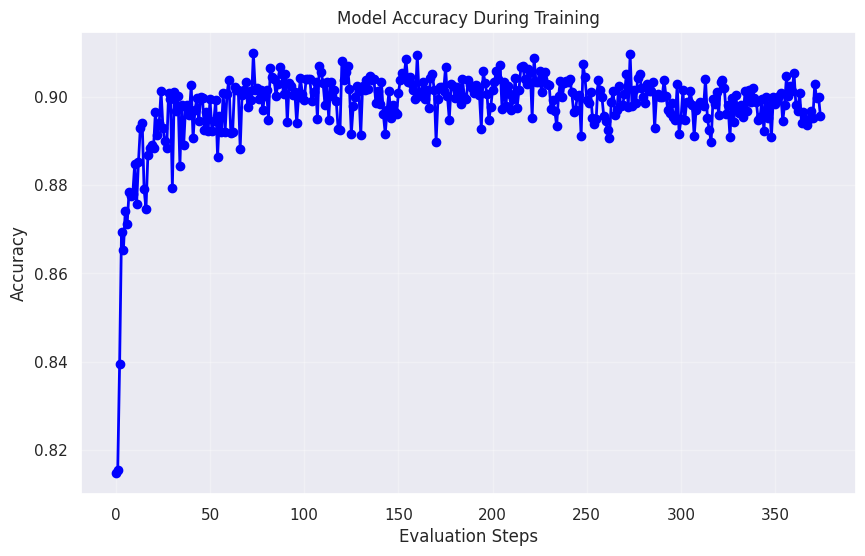

In [38]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 6))
plt.plot(np.arange(len(save_accuracy)), save_accuracy, color='blue', marker='o', linewidth=2)
plt.title('Model Accuracy During Training')
plt.xlabel('Evaluation Steps')
plt.ylabel('Accuracy')
plt.grid(True, alpha=0.3)

best_accuracy = max(save_accuracy)
print(f"Лучшая accuracy: {(best_accuracy * 100):.2f}%")

plt.show()